<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Loading data into a Pyleoclim Series

## Authors
Jordan Landers1

1 Department of Earth Sciences, University of Southern California

Author1 = {"name": "Jordan Landers", "affiliation": "Department of Earth Sciences, University of Southern
California", "email": "lplander@usc.edu", "orcid": "0000-0001-9772-7617"}

## Preamble
The object at the heart of the package is the
[`Series` object](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#series-pyleoclim-series), which describes the fundamentals of a time series. To create a
Pyleoclim `Series`, we first need to load the data set, and then specify values for its various properties:

* `time`: Time values for the time series
* `value`: Paleo values for the time series
* `time_name` (optional): Name of the time vector, (e.g., 'Time', 'Age'). This is used to label the x-axis on plots
* `time_unit` (optional): The units of the time axis (e.g., 'years')
* `value_name` (optional): The name of the paleo variable (e.g., 'Temperature')
* `value_unit` (optional): The units of the paleo variable (e.g., 'deg C')
* `label` (optional): Name of the time series (e.g., 'Nino 3.4')
* `clean_ts` (optional): If True (default), remove NaNs and set an increasing time axis.

Data is stored in different file types, which may need to be ingested in different ways.  Here we present examples of
 how to wrangle CSV, NetCDF, and LiPD files.

### Goals:
* Create Pyleoclim Series from datasets stored as CSV, NetCDF, and LiPD files


**Reading Time:** 5 minutes


<div class="alert alert-warning">
    <bf>Running Time</bf>: Some cells take longer to run (~5min each when loading the data from a NetCDF
</div>

### Keywords

CSV; NetCDF; LiPD, Series; EnsembleSeries

### Pre-requisites

None. This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out this tutorial: http://linked.earth/ec_workshops_py/.

### Relevant Packages

Pandas; Xarray

## Data Description

* McCabe-Glynn, S., Johnson, K., Strong, C. et al. Variable
North Pacific influence on drought in southwestern North America since AD 854. Nature Geosci 6, 617–621 (2013).
[doi:10.1038/ngeo1862](https://doi.org/10.1038/ngeo1862)

* Euro2k database: PAGES2k Consortium., Emile-Geay, J., McKay, N. et al. A global multiproxy database for temperature
 reconstructions of the Common Era. Sci Data 4, 170088 (2017). [doi:10.1038/sdata.2017.88](https://doi.org/10.1038/sdata.2017.88)

* Lisiecki, L. E., and Raymo, M. E. (2005), A Pliocene-Pleistocene stack of 57 globally distributed benthic
δ18O records, Paleoceanography, 20, PA1003, [doi:10.1029/2004PA001071](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071).

## Demonstration
First we import our favorite package:

In [1]:
import pyleoclim as pyleo

### LiPD
Linked Paleo Data format ([LiPD](http://www.clim-past-discuss.net/11/4309/2015/cpd-11-4309-2015-discussion.html)) files contain time series information in addition to supporting metadata (e.g., root metadata, location).
Pyleoclim leverages this additional information using LiPD-specific functionality discussed in greater depth in [this
 tutorial]().

Data stored in the `.lpd` format can be loaded directly into Pyleoclim as a
[Lipd object](https://pyleoclim-util.readthedocs.io/en/master/core/api.html?highlight=lipd#pyleoclim.core.lipd.Lipd).
If the data_path points to one LiPD file, `pyleo.Lipd` will load the specific record, while if data_path points to a
folder of lipd files, `pyleo.Lipd` will load the full set of records.

##### Loading a single LiPD file

In [2]:
data_path = '../data/Crystal.McCabe-Glynn.2013.lpd'
d = pyleo.Lipd(data_path)

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Crystal.McCabe-Glynn.2013.lpd
1.42 MB :That's a big file! This may take a while to load...
Finished read: 1 record


As a check to make sure the LiPD file corresponds to the expected record, we can quickly generate a map that
indicates the location.

(<Figure size 432x288 with 1 Axes>, <GeoAxesSubplot:>)

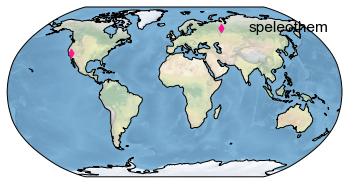

In [3]:
d.mapAllArchive()

##### Loading multiple LiPD files

In [4]:
data_path = '../data/Euro2k/'
d_multiple = pyleo.Lipd(data_path)

Disclaimer: LiPD files may be updated and modified to adhere to standards

Found: 31 LiPD file(s)
reading: Ocn-RedSea.Felis.2000.lpd
reading: Arc-Forfjorddalen.McCarroll.2013.lpd
reading: Eur-Tallinn.Tarand.2001.lpd
reading: Eur-CentralEurope.Dobrovoln.2009.lpd
reading: Eur-EuropeanAlps.Bntgen.2011.lpd
reading: Eur-CentralandEasternPyrenees.Pla.2004.lpd
reading: Arc-Tjeggelvas.Bjorklund.2012.lpd
reading: Arc-Indigirka.Hughes.1999.lpd
reading: Eur-SpannagelCave.Mangini.2005.lpd
reading: Ocn-AqabaJordanAQ19.Heiss.1999.lpd
reading: Arc-Jamtland.Wilson.2016.lpd
reading: Eur-RAPiD-17-5P.Moffa-Sanchez.2014.lpd
reading: Eur-LakeSilvaplana.Trachsel.2010.lpd
reading: Eur-NorthernSpain.Martn-Chivelet.2011.lpd
reading: Eur-MaritimeFrenchAlps.Bntgen.2012.lpd
reading: Ocn-AqabaJordanAQ18.Heiss.1999.lpd
reading: Arc-Tornetrask.Melvin.2012.lpd
reading: Eur-EasternCarpathianMountains.Popa.2008.lpd
reading: Arc-PolarUrals.Wilson.2015.lpd
reading: Eur-LakeSilvaplana.Larocque-Tobler.2010.lpd
reading: Eur

(<Figure size 432x288 with 1 Axes>, <GeoAxesSubplot:>)

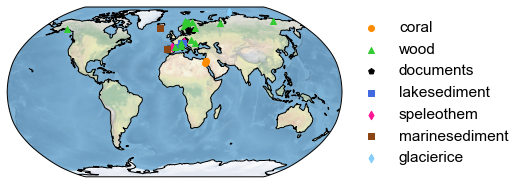

In [5]:
d_multiple.mapAllArchive(lgd_kwargs={'bbox_to_anchor': (1, 1)})

### NetCDF
In order to load data from a NetCDF file, we will use [Xarray](https://docs.xarray.dev/en/stable/index.html).

In [6]:
import xarray as xr

In [7]:
file_path = '../data/p2k_ngeo19_recons.nc'
p2k_nc = xr.open_dataset(file_path)

The coordinates of this data set are `year` and `ens`, and the temperature anamoly is contained in the variable
`LMRv2.1`. Below we extract the timeseries for one ensemble run:

In [8]:
ens_run1 = [p2k_nc.data_vars['LMRv2.1'][ik][0] for ik in range(len(p2k_nc.year))]

To create the `pyleo.Series`, we pass the time coordinate of the dataset, `p2k_nc.year`, as `time`, and `ens_run1`
(extracted from the `p2k_nc` dataset) as `value`. It is optional to specify `time_name` and `time_unit`, and
`value_name` and `value_unit`, but doing so ensures that plot axes are properly labeled.

In [9]:
p2k_ps = pyleo.Series(time=p2k_nc.year, value=ens_run1,
                      time_name='Time', time_unit='year', label = 'LMRv2.1 member #1',
                      value_name='GMST', value_unit='$^{\circ}$C')

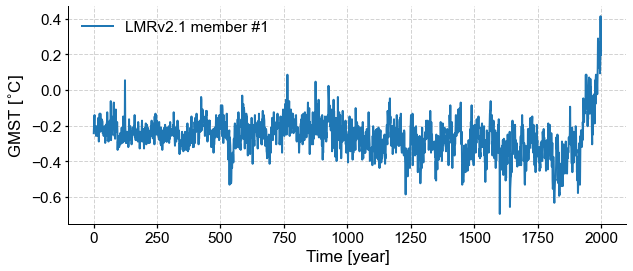

In [10]:
fig, ax = p2k_ps.plot()

However, given this is an ensemble, capturing this data in a `pyleo.EnsembleSeries` will open up opportunities for
specific analysis and visualization. In the cell below, we generate a list of `pyleo.Series` (one for each trace) for
the full set of ensemble runs in much the same way as above.

In [12]:
%%time

ts_list = []

for im in range(len(p2k_nc.ens)):
    ens_run = [p2k_nc.data_vars['LMRv2.1'][ik][im] for ik in range(len(p2k_nc.year))]
    ts_list.append(pyleo.Series(time=p2k_nc.year, value=ens_run,
                      time_name='Time', time_unit='year CE',
                      value_name='Temperature anomaly', value_unit='$^{\circ}$C'))

KeyboardInterrupt: 

Then we simply pass `ts_list` to `pyleo.EnsembleSeries`...

In [42]:
ts_ens = pyleo.EnsembleSeries(ts_list)

For more detail on visualizing `pyleo.EnsembleSeries`, check out the tutorial on [Basic operations with
MultipleSeries and EnsembleSeries](), but we can use `plot_traces()` to quickly check to make sure the data seems
properly organized (by default, `plot_traces()` plots 10 randomly selected traces).

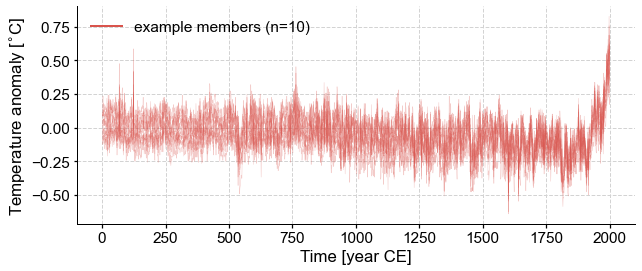

In [43]:
fig, ax = ts_ens.plot_traces()

### CSV
CSV files have a table structure, so we will use [Pandas]() and the read the data into a pandas `DataFrame`.

In [44]:
import pandas as pd

In [45]:
LR04 = pd.read_csv('../data/LR04.csv', header=4)
LR04.head()

,Time (ka),Benthic d18O (per mil),Standard error (per mil)
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03


In [46]:
LR04.columns

Index(['Time (ka)', 'Benthic d18O (per mil)  ', 'Standard error (per mil)'], dtype='object')

To create a `pyleo.Series`, we pass the `Time (ka)` column as `time` and the `Benthic d18O (per mil)` column as `value`. Note the extra space at the end of that column name! We have to work with what the interwebs give us.

In [47]:
LR04_ps = pyleo.Series(time=LR04['Time (ka)'], value=LR04['Benthic d18O (per mil)  '],
                      time_name='Time', time_unit='ka',
                      value_name='$\delta^{18}$O', value_unit=u'‰')

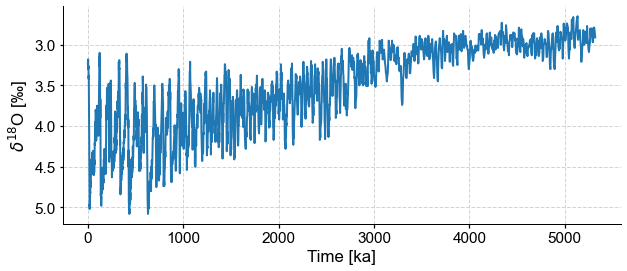

In [48]:
fig, ax = LR04_ps.plot()
ax.invert_yaxis()